# Variational Auto-Encoder
See [vae.py](../vae.py) to see Tensorflow Variational Auto-Encoder implementation used in this notebook.

**Table of content**
1. [Variational Auto-Encoder](#Variational-Auto-Encoder)  
    1.1 [Imports and data loading](#Imports-and-data-loading)  
    1.2 [Train VAE on MNIST dataset](#Train-VAE-on-MNIST-dataset)  
    1.3 [Training VAE on NYC taxi trip](#Training-VAE-on-NYC-taxi-trip)  

## Imports and data loading

In [5]:
from IPython.display import display, Markdown, Latex
import tensorflow as tf
import pandas as pd
import numpy as np
import importlib
import sys
import os

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

module_path = os.path.abspath('../')
if module_path not in sys.path:
    sys.path.append(module_path)

import vae
import utils
import feature_engineering

def reload():
    _ = importlib.reload(vae)
    _ = importlib.reload(utils)
    _ = importlib.reload(feature_engineering)
reload()

We first use MNIST dataset to verify that our VAE performs well:

In [2]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
mnist = read_data_sets('MNIST_data', one_hot=True)
N = 28*28 # MNIST data input dimentionality

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


max(min_x)=0.0


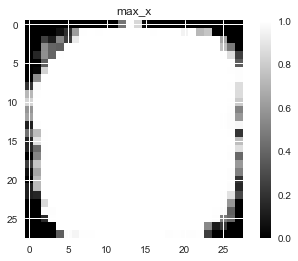

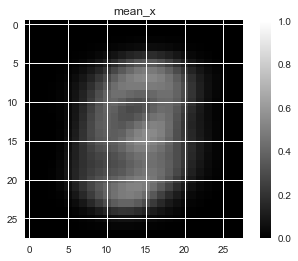

In [3]:
# Process basic MNIST statistics
def process_statistics():
    batch_xs, _ = mnist.train.next_batch(mnist.train.num_examples)
    return np.mean(batch_xs, axis=0), np.min(batch_xs, axis=0), np.max(batch_xs, axis=0)
mean_x, min_x, max_x = process_statistics()

# Show resulting mean, min and max for each input features
def show_mnist(array, title=''):
    bitmap = np.reshape(array, (28, 28))
    plt.imshow(bitmap, vmin=0, vmax=1, cmap="gray")
    plt.title(title)
    plt.colorbar()
    plt.show()

print('max(min_x)=' + str(max(min_x)))
show_mnist(max_x, 'max_x')
show_mnist(mean_x, 'mean_x')

Then we will train on NYC taxi trip dataset:

________________________________________________________________________________
[Memory] Calling feature_engineering._cached_light_load_data...
_cached_light_load_data('../NYC_taxi_data_2016/', 'train.csv', 'test.csv', 100000, 8, 64)
__________________________________________cached_light_load_data - 38.9s, 0.6min


train_data.shape = (1358644, 17)

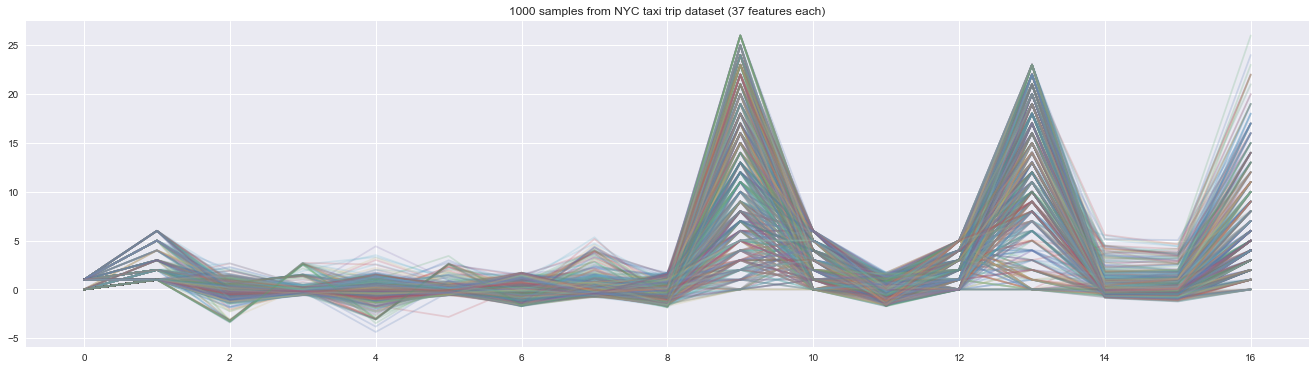

In [6]:
# Parse and preprocess data
VALID_SIZE = 100000
TARGET_SIZE = 512

features_len, discrete_feats, (test_ids, testset), dataset, bucket_means = feature_engineering.load_data('../NYC_taxi_data_2016/', 'train.csv', 'test.csv', VALID_SIZE, TARGET_SIZE,
                                                                                                         max_distinct_values=64, embed_discrete_features=8, cache_read_only=False)
(train_data, valid_data, train_targets, valid_targets, train_labels, valid_labels) = dataset
display(Markdown('train_data.shape = ' + str(train_data.shape)))

# Plot some samples from NYC taxi trip dataset
def plot_nyc_samples(samples, figsize=(23, 6), alpha=1., title='NYC taxi trip samples'):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.plot(np.transpose(samples), alpha=alpha)
    plt.show()
plot_nyc_samples(train_data[:1000], alpha=0.2, title='1000 samples from NYC taxi trip dataset (37 features each)')

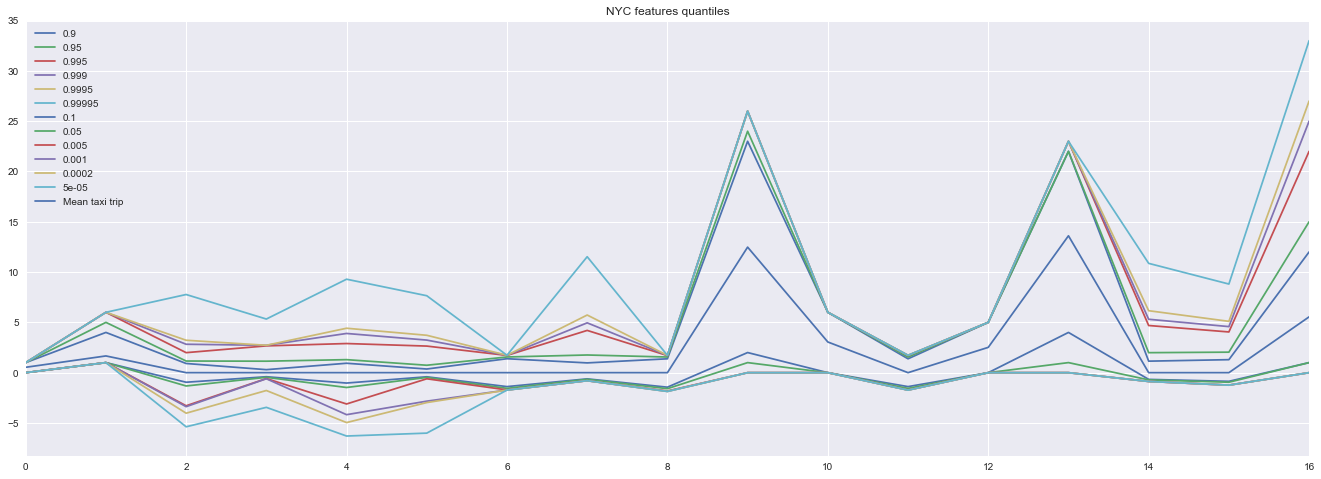

In [7]:
# Process basic statistics on NYC Taxi trip features
nyc_mean_x = np.mean(train_data, axis=0)
df = pd.DataFrame(train_data)
quantiles = df.quantile([0.9, 0.95, 0.995, 0.999, 0.9995, 0.99995, 0.1, 0.05, 0.005, 0.001, 0.0002, 0.00005]).transpose()
quantiles['Mean taxi trip'] = (pd.Series(nyc_mean_x))
quantiles.plot(figsize=(23, 8), title='NYC features quantiles')
# Let's take 0.0002 and 0.9995 quantiles instead of real min/max as there are some outliers
nyc_min_x, nyc_max_x = np.array(quantiles[0.0002]), np.array(quantiles[0.9995])

## Train VAE on MNIST dataset

In [159]:
reload()
def train_mnist(layout, epochs, lr=0.1, batch_size=128, display_step=4, batch_norm=False, keep_prob=1., clipping_threshold=None):
    tf.reset_default_graph()
    Vae = vae.VariationalAutoencoder(**layout, min_x=min_x, max_x=max_x, lr=lr, batch_size=batch_size, batch_norm=batch_norm, keep_prob=keep_prob, clipping_threshold=clipping_threshold)
    print('VAE tensorflow computation graph created.')
    
    # Training loop
    for epoch in range(epochs):
        avg_loss = 0.
        batch_count = int(mnist.train.num_examples / batch_size)
        # Loop over all data batches
        for i in range(batch_count):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            # Train on batch_xs
            loss = Vae.fit_batch(batch_xs)
            # Update average loss
            avg_loss += loss / mnist.train.num_examples * batch_size

        if epoch % display_step == 0:
            print("Epoch=%04d" % (epoch + 1), "loss={:.7f}".format(avg_loss))
    return Vae

In [164]:
layout = {'encoder_layers': [1024, 512, 256, 128],
          'decoder_layers': [128, 256, 512, 1024],
          'n_inputs': N,
          'n_z': 20}

Vae = train_mnist(layout, lr=0.2, epochs=80)

VAE tensorflow computation graph created.
Epoch=0001 loss=0.2538401
Epoch=0005 loss=0.1692291
Epoch=0009 loss=0.1520325
Epoch=0013 loss=0.1440388
Epoch=0017 loss=0.1396364
Epoch=0021 loss=0.1370557
Epoch=0025 loss=0.1348404
Epoch=0029 loss=0.1332051
Epoch=0033 loss=0.1317049
Epoch=0037 loss=0.1305368
Epoch=0041 loss=0.1297619
Epoch=0045 loss=0.1288118
Epoch=0049 loss=0.1280816
Epoch=0053 loss=0.1274221
Epoch=0057 loss=0.1266393
Epoch=0061 loss=0.1261224
Epoch=0065 loss=0.1255069
Epoch=0069 loss=0.1250949
Epoch=0073 loss=0.1249565
Epoch=0077 loss=0.1242896


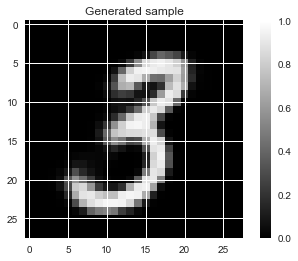

In [168]:
bitmap = np.reshape(Vae.decode(np.random.normal(size=(1, 20))), (28, 28))
plt.imshow(bitmap, vmin=0, vmax=1, cmap="gray")
plt.title("Generated sample")
plt.colorbar()

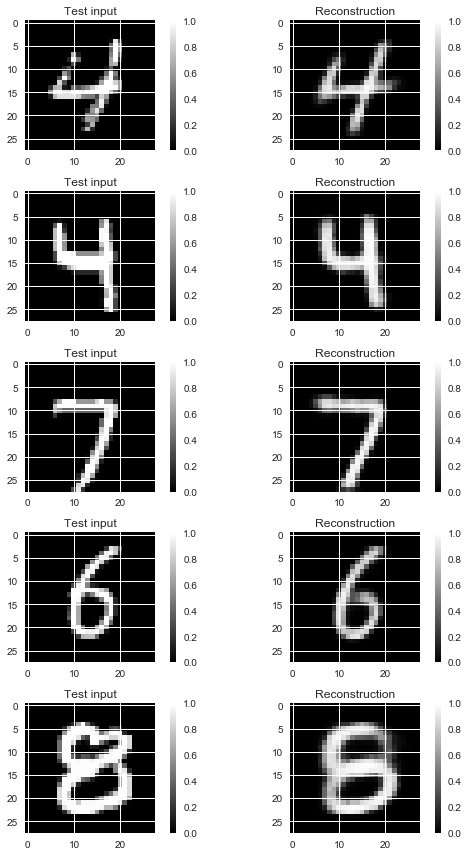

In [169]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = Vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [170]:
# Define a new VAE with 2-dimensional latent space
layout = {'encoder_layers': [1024, 512, 256, 128],
          'decoder_layers': [128, 256, 512, 1024],
          'n_inputs': N,
          'n_z': 2}
Vae_2d = train_mnist(layout, lr=0.2, epochs=80)

VAE tensorflow computation graph created.
Epoch=0001 loss=0.2544331
Epoch=0005 loss=0.2064632
Epoch=0009 loss=0.1962188
Epoch=0013 loss=0.1905122
Epoch=0017 loss=0.1870082
Epoch=0021 loss=0.1845068
Epoch=0025 loss=0.1827941
Epoch=0029 loss=0.1815700
Epoch=0033 loss=0.1800158
Epoch=0037 loss=0.1798669
Epoch=0041 loss=0.1790938
Epoch=0045 loss=0.1779810
Epoch=0049 loss=0.1794042
Epoch=0053 loss=0.1773217
Epoch=0057 loss=0.1769853
Epoch=0061 loss=0.1764727
Epoch=0065 loss=0.1792283
Epoch=0069 loss=0.1768039
Epoch=0073 loss=0.1755967
Epoch=0077 loss=0.1752595


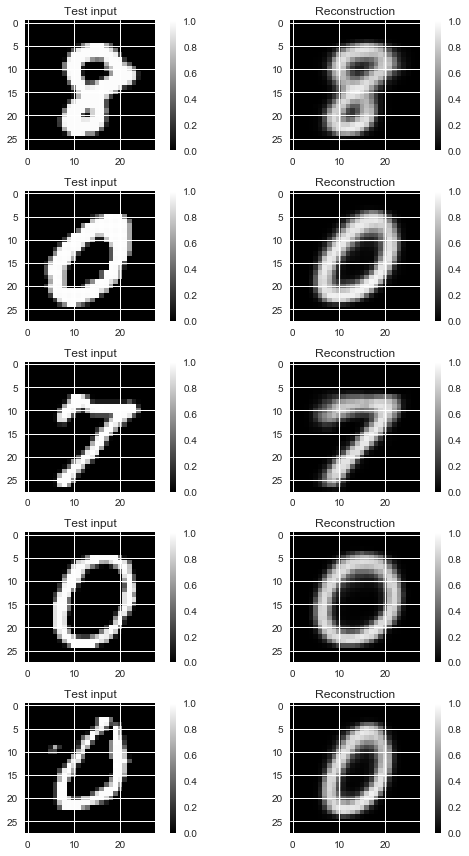

In [172]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = Vae_2d.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

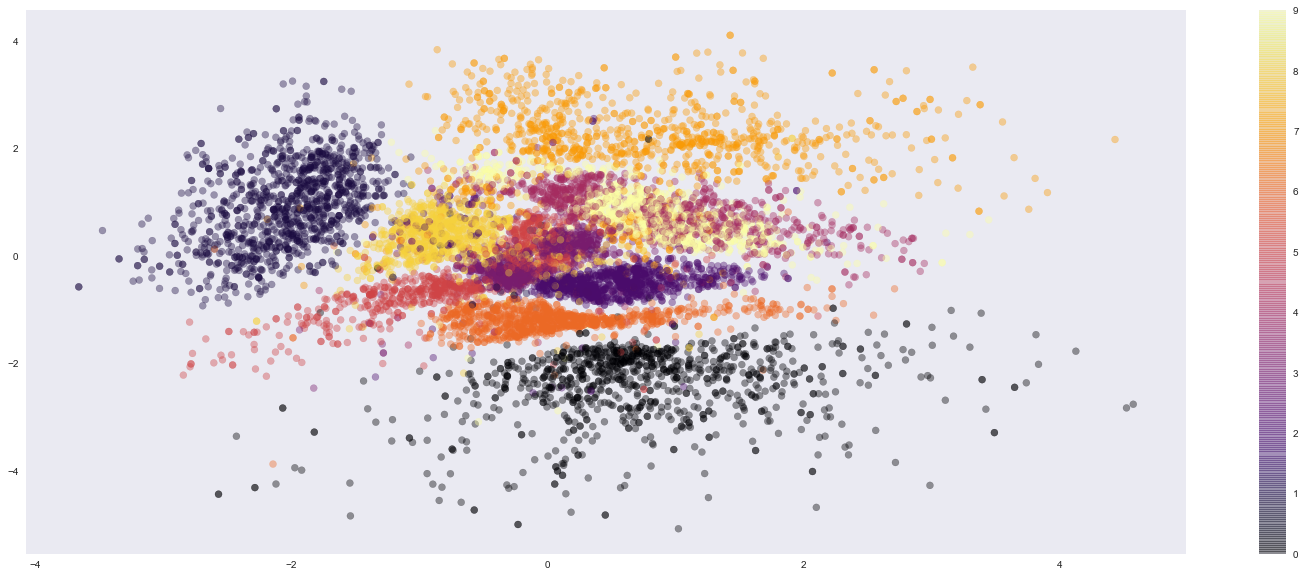

In [173]:
# Apply encoder to test data
x_sample, y_sample = mnist.test.next_batch(10000)
z_mu, z_sq_log_stddev = Vae_2d.encode(x_sample)
# Visualize obtained latent vectors
fig = plt.figure(figsize=(26, 10))
plot = plt.scatter(z_mu[:,0], z_mu[:,1], alpha=0.4, c=np.argmax(y_sample, axis=1), cmap='inferno')
plt.colorbar()
plt.grid()

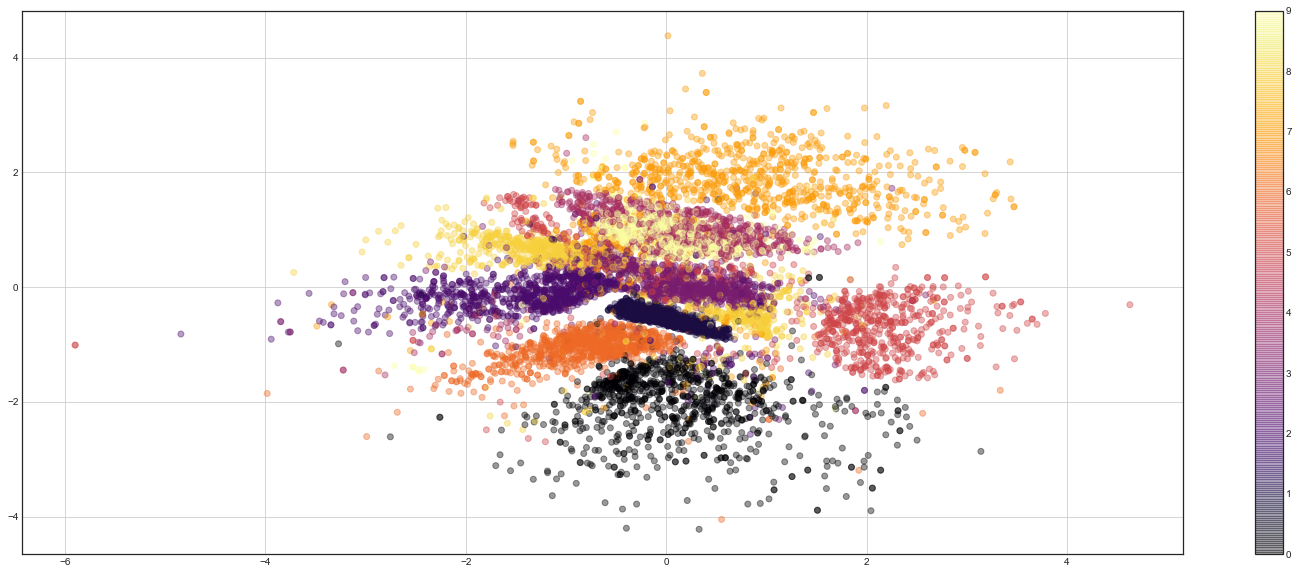

In [29]:
# Apply encoder to test data
x_sample, y_sample = mnist.test.next_batch(10000)
z_mu, z_sq_log_stddev = Vae_2d.encode(x_sample)
# Visualize obtained latent vectors
fig = plt.figure(figsize=(26, 10))
plot = plt.scatter(z_mu[:,0], z_mu[:,1], alpha=0.4, c=np.argmax(y_sample, axis=1), cmap='inferno')
plt.colorbar()
plt.grid()

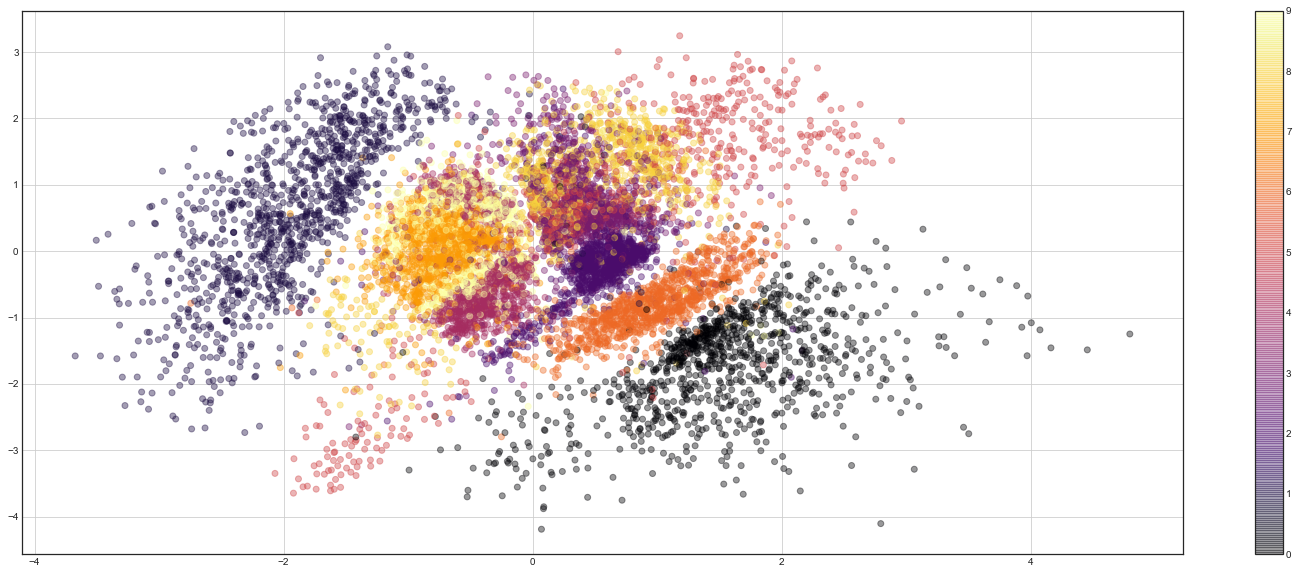

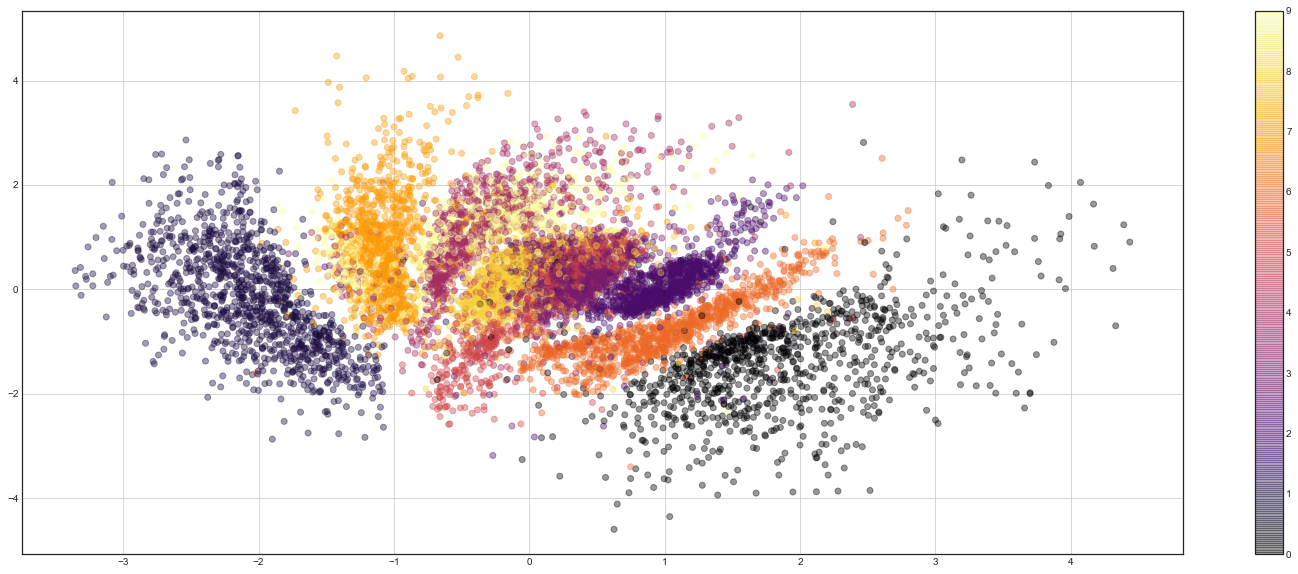

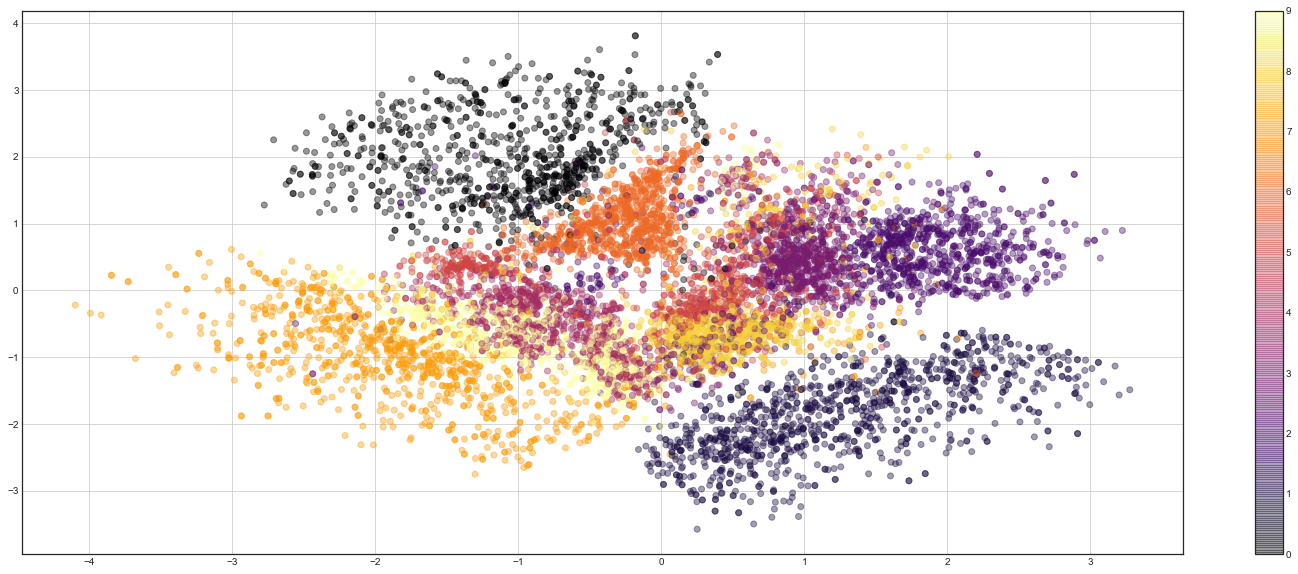

## Training VAE on NYC taxi trip

In [7]:
reload()
def train_nyc(layout, epochs, lr=1e-4, batch_size=256, display_step=1, batch_norm=False, keep_prob=1., clipping_threshold=None):
    tf.reset_default_graph()
    Vae = vae.VariationalAutoencoder(**layout, min_x=nyc_min_x, max_x=nyc_max_x, lr=lr, batch_size=batch_size, batch_norm=batch_norm, keep_prob=keep_prob, clipping_threshold=clipping_threshold)
    print('VAE tensorflow computation graph created.')
    
    # We train on all available data (unsupervised)
    data = np.concatenate((train_data, valid_data, testset))
    
    # Training loop
    batches = np.array_split(data, len(data) // batch_size)
    for epoch in range(epochs):
        avg_loss = 0.
        # Loop over all data batches
        for batch_xs in batches:
            # Train on batch_xs
            loss = Vae.fit_batch(batch_xs)
            # Update average loss
            avg_loss += loss / len(train_data) * len(batch_xs)
        np.random.shuffle(batches)
        if epoch % display_step == 0:
            print("Epoch=%04d" % (epoch + 1), "loss={:.9f}".format(avg_loss))
    return Vae

In [8]:
layout = {'encoder_layers': [1024, 512, 256, 128],
          'decoder_layers': [128, 256, 512, 1024],
          'n_inputs': 37,
          'n_z': 8}

#Vae8 = train_nyc(layout, lr=0.001, epochs=50)
Vae7 = train_nyc(layout, lr=0.005, epochs=50)
Vae6 = train_nyc(layout, lr=0.01, epochs=50)

VAE tensorflow computation graph created.
Epoch=0001 loss=0.772615948
Epoch=0002 loss=0.760479098
Epoch=0003 loss=0.759851016
Epoch=0004 loss=0.759679925
Epoch=0005 loss=0.759657961
Epoch=0006 loss=0.759567500
Epoch=0007 loss=0.759521715
Epoch=0008 loss=0.759419846
Epoch=0009 loss=0.759269633
Epoch=0010 loss=0.758564209
Epoch=0011 loss=0.757723057
Epoch=0012 loss=0.756853334
Epoch=0013 loss=0.755532672
Epoch=0014 loss=0.755157762
Epoch=0015 loss=0.755064630
Epoch=0016 loss=0.755004609
Epoch=0017 loss=0.755005181
Epoch=0018 loss=0.754931834
Epoch=0019 loss=0.754901807
Epoch=0020 loss=0.754879281
Epoch=0021 loss=0.754852498
Epoch=0022 loss=0.754813746
Epoch=0023 loss=0.754783079
Epoch=0024 loss=0.754799606
Epoch=0025 loss=0.754740771
Epoch=0026 loss=0.754736540
Epoch=0027 loss=0.754721806
Epoch=0028 loss=0.754634624
Epoch=0029 loss=0.754552706
Epoch=0030 loss=0.754442677
Epoch=0031 loss=0.754305614
Epoch=0032 loss=0.754161566
Epoch=0033 loss=0.754082381
Epoch=0034 loss=0.754001673
Epoch=

In [16]:
layout = {'encoder_layers': [1024, 512, 256, 128],
          'decoder_layers': [128, 256, 512, 1024],
          'n_inputs': 37,
          'n_z': 8}

Vae2 = train_nyc(layout, epochs=6)

layout = {'encoder_layers': [1024, 512, 256, 128],
          'decoder_layers': [128, 256, 512, 1024],
          'n_inputs': 37,
          'n_z': 80}

Vae3 = train_nyc(layout, epochs=6)

layout = {'encoder_layers': [1024, 512, 256, 128],
          'decoder_layers': [128, 256, 512, 1024],
          'n_inputs': 37,
          'n_z': 37}

Vae4 = train_nyc(layout, epochs=6)

VAE tensorflow computation graph created.
Epoch=0001 loss=37.435851986
Epoch=0002 loss=34.268463392
Epoch=0003 loss=34.028570228
Epoch=0004 loss=33.980320219
Epoch=0005 loss=33.967889083
Epoch=0006 loss=33.963176033
VAE tensorflow computation graph created.
Epoch=0001 loss=43.137234079
Epoch=0002 loss=34.216137122
Epoch=0003 loss=34.029859857
Epoch=0004 loss=33.985768727
Epoch=0005 loss=33.971946937
Epoch=0006 loss=33.967919544
VAE tensorflow computation graph created.
Epoch=0001 loss=40.766975004
Epoch=0002 loss=34.236066430
Epoch=0003 loss=34.042222799
Epoch=0004 loss=33.986888347
Epoch=0005 loss=33.972263985
Epoch=0006 loss=33.965805729


In [134]:
layout = {'n_hidden_encoder': 512,
          'n_hidden_decoder': 512,
          'n_encoder_layers': 5,
          'n_decoder_layers': 5,
          'n_inputs': 37,
          'n_z': 8}

Vae = train_nyc(layout, epochs=13)

VAE tensorflow computation graph created.
Epoch=0001 loss=37.370216288
Epoch=0002 loss=34.233731314
Epoch=0003 loss=34.023588513
Epoch=0004 loss=33.979223143
Epoch=0005 loss=33.966099791
Epoch=0006 loss=33.960271940
Epoch=0007 loss=33.959640119
Epoch=0008 loss=33.956134052
Epoch=0009 loss=33.953367671
Epoch=0010 loss=33.951363626
Epoch=0011 loss=33.951581364
Epoch=0012 loss=33.950297804
Epoch=0013 loss=33.947193035


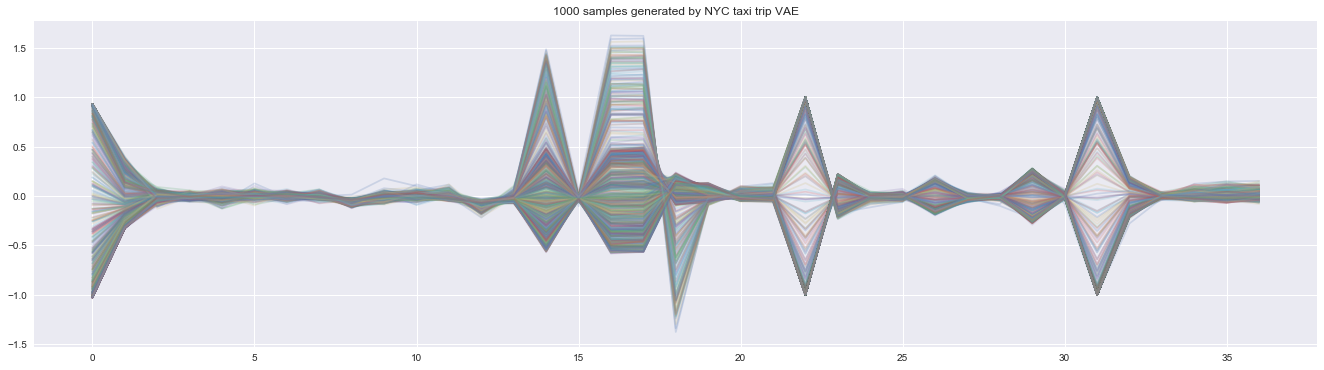

In [9]:
generated_samples = Vae7.decode(np.random.normal(size=(1000, 8)))
plot_nyc_samples(generated_samples, alpha=0.2, title='1000 samples generated by NYC taxi trip VAE')

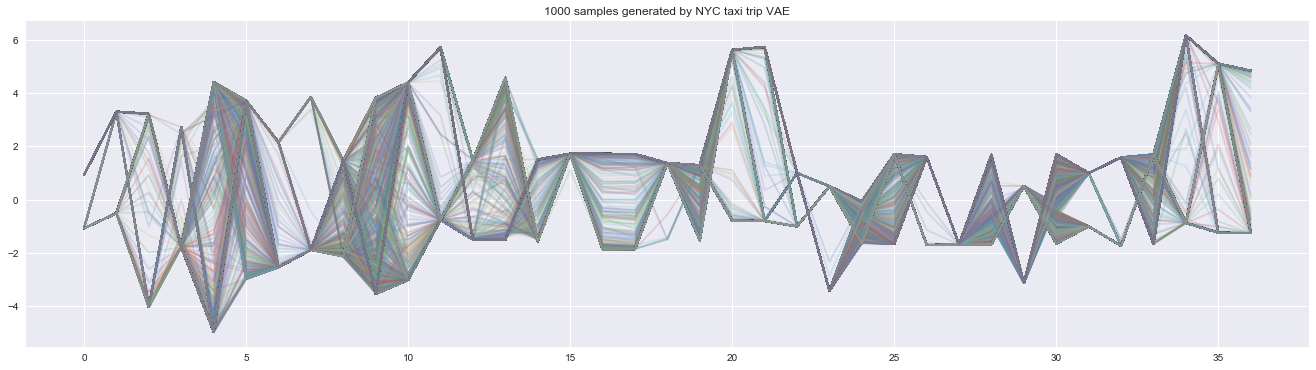

In [150]:
generated_samples = Vae.decode(np.random.normal(size=(1000, 8)))
plot_nyc_samples(generated_samples, alpha=0.2, title='1000 samples generated by NYC taxi trip VAE')

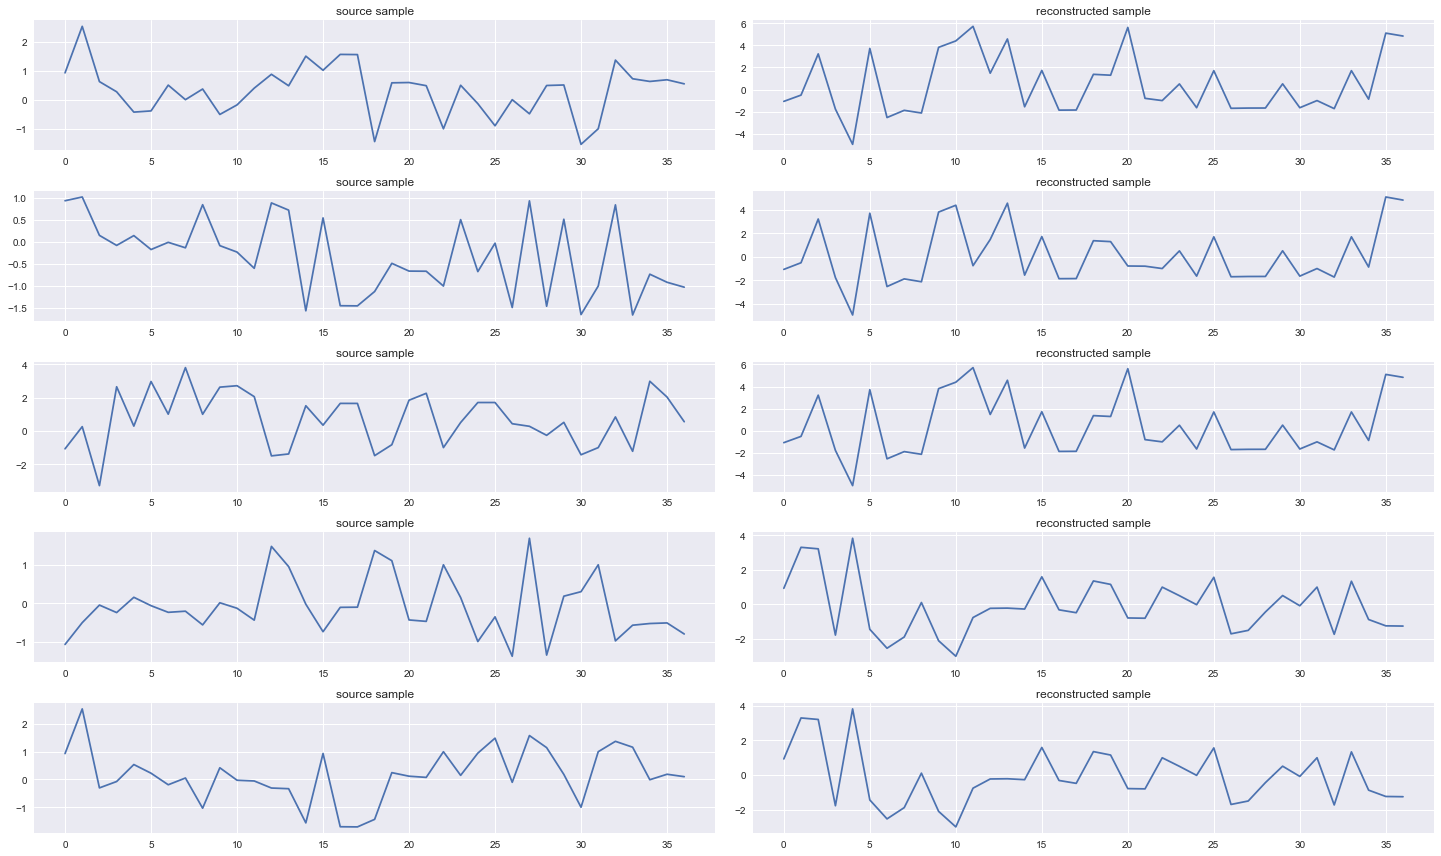

In [151]:
x_samples = train_data[np.random.choice(len(train_data), 5)]
x_reconstruct = Vae.reconstruct(x_samples)

plt.figure(figsize=(20, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.title('source sample')
    plt.plot(np.transpose(x_samples[i]))
    plt.subplot(5, 2, 2*i + 2)
    plt.title('reconstructed sample')
    plt.plot(np.transpose(x_reconstruct[i]))
plt.tight_layout()

In [105]:
# Train another VAE with 2D latent space for visualization purpose
layout = {'n_hidden_encoder': 512,
          'n_hidden_decoder': 512,
          'n_encoder_layers': 4,
          'n_decoder_layers': 4,
          'n_inputs': 37,
          'n_z': 2}
Vae_2d = train_nyc(layout, epochs=10)

VAE tensorflow computation graph created.
Epoch=0001 loss=38.247223981
Epoch=0002 loss=35.023927593
Epoch=0003 loss=34.225969975
Epoch=0004 loss=34.064667364
Epoch=0005 loss=34.008134496
Epoch=0006 loss=33.981812997
Epoch=0007 loss=33.968513658
Epoch=0008 loss=33.961765588
Epoch=0009 loss=33.955902255
Epoch=0010 loss=33.952578331


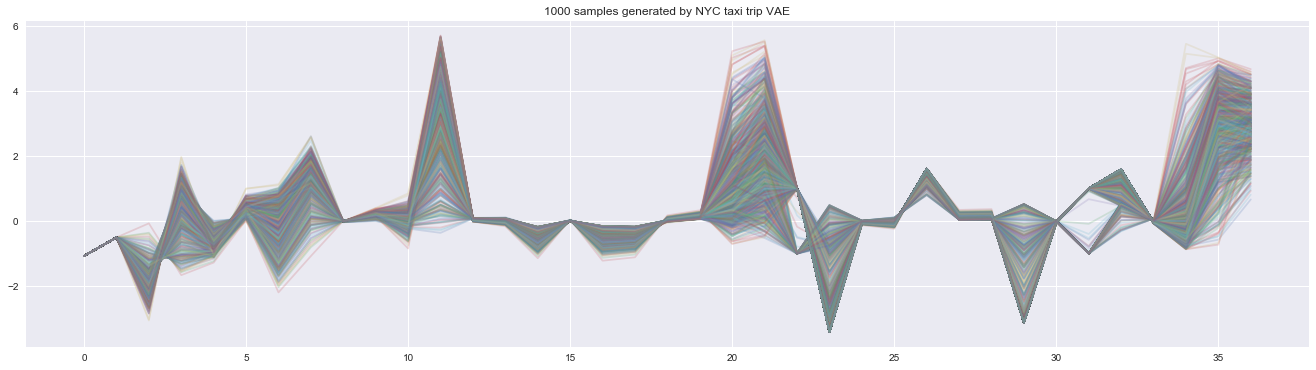

In [112]:
generated_samples = Vae_2d.decode(np.random.normal(size=(1000, 2)))
plot_nyc_samples(generated_samples, alpha=0.2, title='1000 samples generated by NYC taxi trip VAE')

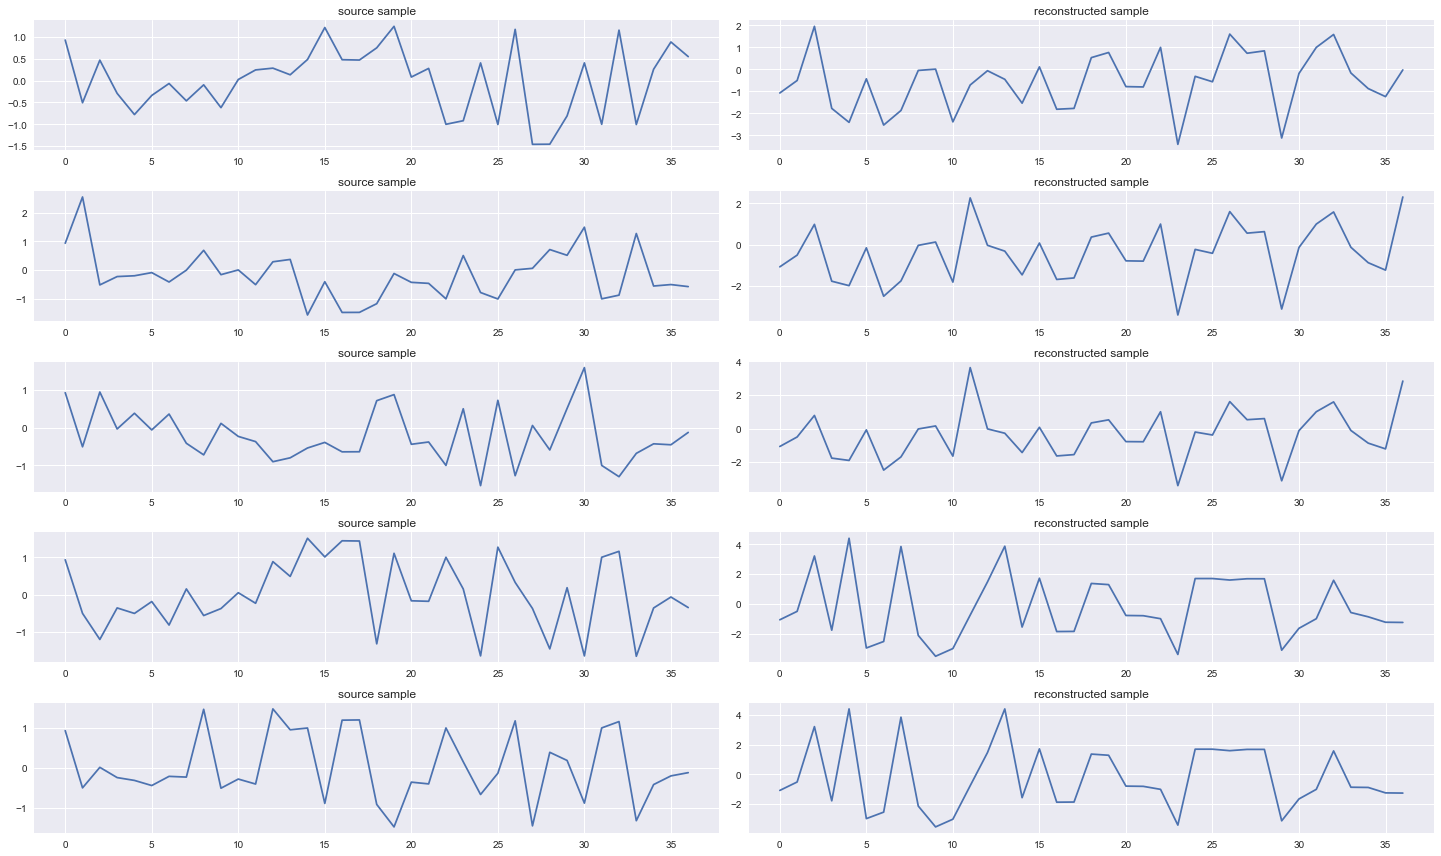

In [118]:
x_samples = train_data[np.random.choice(len(train_data), 5)]
x_reconstruct = Vae_2d.reconstruct(x_samples)

plt.figure(figsize=(20, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.title('source sample')
    plt.plot(np.transpose(x_samples[i]))
    plt.subplot(5, 2, 2*i + 2)
    plt.title('reconstructed sample')
    plt.plot(np.transpose(x_reconstruct[i]))
plt.tight_layout()

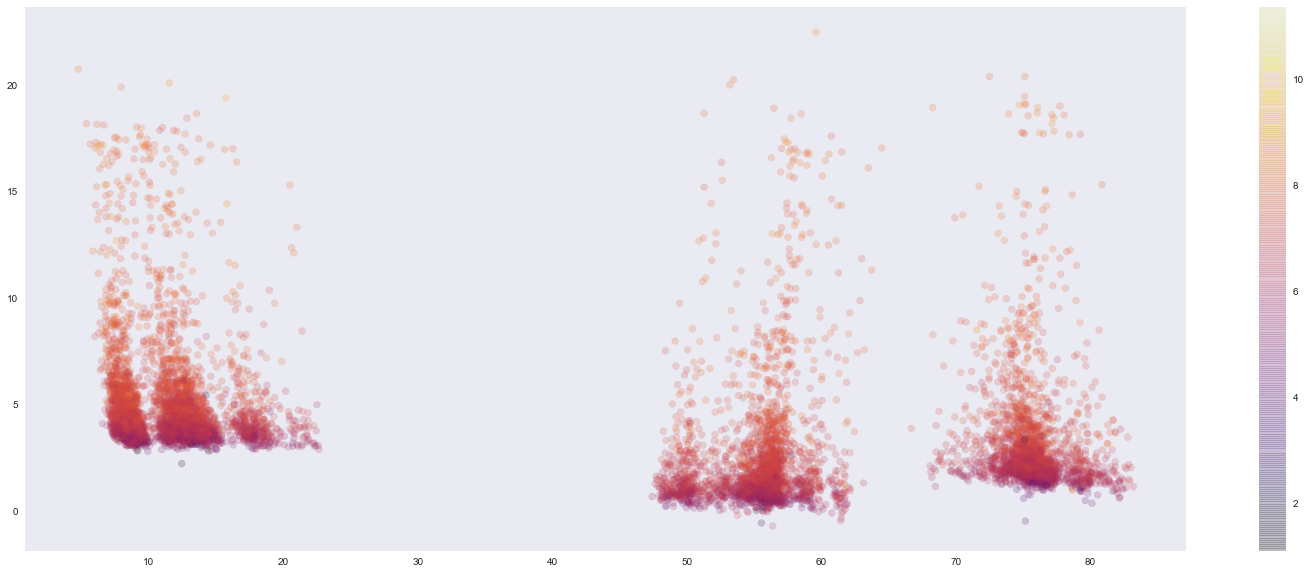

In [131]:
# Plot 2D latent vectors with color gradient defined by taxi trip duration
choices = np.random.choice(len(train_data), 10000)
x_sample, y_sample = train_data[choices], train_targets[choices]
z_mu, z_sq_log_stddev = Vae_2d.encode(x_sample)
# Visualize obtained latent vectors
fig = plt.figure(figsize=(26, 10))
plot = plt.scatter(z_mu[:,0], z_mu[:,1], alpha=0.2, c=y_sample, cmap='inferno')
plt.colorbar()
plt.grid()

In [ ]:
# Process latent vectors for the whole taxi trip dataset
train_latents, _ = Vae.encode(train_data)
valid_latents, _ = Vae.encode(valid_data)
test_latents, _ = Vae.encode(testset)
# Save latent vectors
with open('./vae-train-latents.npz', 'wb') as file:
    np.save(file, train_latents)
with open('./vae-valid-latents.npz', 'wb') as file:
    np.save(file, valid_latents)
with open('./vae-test-latents.npz', 'wb') as file:
    np.save(file, test_latents)

## Training XGBoost on top of NYC taxi trip VAE features

In [ ]:
# TODO: